In [60]:
%matplotlib inline

import pandas as pd
import matplotlib
import numpy as np
import random
from sklearn import tree
from IPython.display import Image
from sklearn.externals.six import StringIO
import pydot
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter('ignore')

In [34]:
data=pd.read_csv('pcr_2014.csv')
data.shape

(996179, 47)

In [47]:
data["PROVIDERSPRIMARYIMPRESSION"].value_counts()

Not Available                                166959
Not Applicable                               162077
959.90- Traumatic injury                     118512
312.90- Behavioral / psychiatric disorder     75838
786.09- Respiratory distress                  65233
789.00- Abdominal pain / problems             59668
786.50- Chest pain / discomfort               44923
780.20- Syncope / fainting                    34057
780.09- Altered level of consciousness        33312
977.90- Poisoning / drug ingestion            30117
Not Reporting                                 29611
780.30- Seizure                               27639
Not Known                                     17889
250.90- Diabetic symptoms (hypoglycemia)      16799
436.00- Stroke / CVA                          13432
Not Recorded                                  10216
427.90- Cardiac rhythm disturbance            10076
427.50- Cardiac arrest                         7523
659.90- Pregnancy / OB delivery                5214
995.30- Alle

In [39]:
# Filter out labels that aren't the following five
#blah=data[data['INCIDENTPATIENTDISPOSITION'].isin(['Treated, Transported by EMS', 'Patient Refused Care','Treated and Released','No Treatment Required','Dead at Scene'])]
# Reset indices
#blah.reset_index()
#blah.shape

blah=data[~data['PROVIDERSPRIMARYIMPRESSION'].isin(['Not Available','Not Applicable','Not Reporting', 'Not Known','Not Recorded'])]
blah.reset_index()
blah.shape

(609427, 47)

In [61]:
# Replace "not available" values with NaN
blah[blah.isin(['Not Applicable'])]=np.NaN
blah[blah.isin(['Not Known'])]=np.NaN
blah[blah.isin(['Not Available'])]=np.NaN
blah[blah.isin(['Not Recorded'])]=np.NaN
blah[blah.isin(['Not Reporting'])]=np.NaN
blah[blah.isin(['Unk'])]=np.NaN

# Replace missing data with mode for each column
blah['PRIMARYSYMPTOM']=blah['PRIMARYSYMPTOM'].fillna(blah['PRIMARYSYMPTOM'].mode()[0])
blah['CAUSEOFINJURY']=blah['CAUSEOFINJURY'].fillna(blah['CAUSEOFINJURY'].mode()[0])
blah['INCIDENTLOCATIONTYPE']=blah['INCIDENTLOCATIONTYPE'].fillna(blah['INCIDENTLOCATIONTYPE'].mode()[0])
blah['COMPLAINTANATOMICLOCATION']=blah['COMPLAINTANATOMICLOCATION'].fillna(blah['COMPLAINTANATOMICLOCATION'].mode()[0])
blah['IS_INJURY']=blah['IS_INJURY'].fillna(blah['IS_INJURY'].mode()[0])
blah['CARDIACARREST']=blah['CARDIACARREST'].fillna(blah['CARDIACARREST'].mode()[0])
blah['COMPLAINTREPORTEDBYDISPATCH']=blah['COMPLAINTREPORTEDBYDISPATCH'].fillna(blah['COMPLAINTREPORTEDBYDISPATCH'].mode()[0])
blah['SCENE_COUNTY']=blah['SCENE_COUNTY'].fillna(blah['SCENE_COUNTY'].mode()[0])

In [62]:
# Categorical hash
injury_labels = list(blah["CAUSEOFINJURY"].unique())
symptom_labels = list(blah["PRIMARYSYMPTOM"].unique())
location_labels = list(blah["INCIDENTLOCATIONTYPE"].unique())
anatomy_labels = list(blah["COMPLAINTANATOMICLOCATION"].unique())
is_labels = list(blah["IS_INJURY"].unique())
cardiac_labels = list(blah["CARDIACARREST"].unique())
complaint_labels = list(blah["COMPLAINTREPORTEDBYDISPATCH"].unique())
county_labels = list(blah["SCENE_COUNTY"].unique())

disposition_labels = list(blah["INCIDENTPATIENTDISPOSITION"].unique())
prov_primary_impress_labels = list(blah["PROVIDERSPRIMARYIMPRESSION"].unique())
prov_secondary_impress_labels = list(blah["PROVIDERSSECONDARYIMPRESSION"].unique())

blah["CAUSEOFINJURY_CAT"] = blah["CAUSEOFINJURY"].apply(lambda x: injury_labels.index(x))
blah["PRIMARYSYMPTOM_CAT"] = blah["PRIMARYSYMPTOM"].apply(lambda x: symptom_labels.index(x))
blah["INCIDENTLOCATIONTYPE_CAT"] = blah["INCIDENTLOCATIONTYPE"].apply(lambda x: location_labels.index(x))
blah["COMPLAINTANATOMICLOCATION_CAT"] = blah["COMPLAINTANATOMICLOCATION"].apply(lambda x: anatomy_labels.index(x))
blah["IS_INJURY_CAT"] = blah["IS_INJURY"].apply(lambda x: is_labels.index(x))
blah["CARDIACARREST_CAT"] = blah["CARDIACARREST"].apply(lambda x: cardiac_labels.index(x))
blah["COMPLAINTREPORTEDBYDISPATCH_CAT"] = blah["COMPLAINTREPORTEDBYDISPATCH"].apply(lambda x: complaint_labels.index(x))
blah["SCENE_COUNTY_CAT"] = blah["SCENE_COUNTY"].apply(lambda x: county_labels.index(x))

blah["PROVIDERSPRIMARYIMPRESSION_CAT"] = blah["PROVIDERSPRIMARYIMPRESSION"].apply(lambda x: prov_primary_impress_labels.index(x))
blah["PROVIDERSSECONDARYIMPRESSION_CAT"] = blah["PROVIDERSSECONDARYIMPRESSION"].apply(lambda x: prov_secondary_impress_labels.index(x))
blah["INCIDENTPATIENTDISPOSITION_CAT"] = blah["INCIDENTPATIENTDISPOSITION"].apply(lambda x: disposition_labels.index(x))

In [42]:
# Randomize order of rows
index = list(blah.index)
random.shuffle(index)
blah = blah.ix[index]
blah.reset_index()
blah.shape

(609427, 58)

In [43]:
# Dividing test and training
k=0.9
splitk=int(round(blah.shape[0]*k))

# Use only Primarysymptom and Causeofinjury features
onehot1 = {k:v for k,v in zip(injury_labels, pd.get_dummies(injury_labels).as_matrix())}
onehot2 = {k:v for k,v in zip(symptom_labels, pd.get_dummies(symptom_labels).as_matrix())}
onehot3 = {k:v for k,v in zip(location_labels, pd.get_dummies(location_labels).as_matrix())}
onehot4 = {k:v for k,v in zip(anatomy_labels, pd.get_dummies(anatomy_labels).as_matrix())}
onehot5 = {k:v for k,v in zip(is_labels, pd.get_dummies(is_labels).as_matrix())}
onehot6 = {k:v for k,v in zip(cardiac_labels, pd.get_dummies(cardiac_labels).as_matrix())}
onehot7 = {k:v for k,v in zip(complaint_labels, pd.get_dummies(complaint_labels).as_matrix())}
onehot8 = {k:v for k,v in zip(county_labels, pd.get_dummies(county_labels).as_matrix())}
temp1=blah['CAUSEOFINJURY'].as_matrix()
temp2=blah['PRIMARYSYMPTOM'].as_matrix()
temp3=blah['INCIDENTLOCATIONTYPE'].as_matrix()
temp4=blah['COMPLAINTANATOMICLOCATION'].as_matrix()
temp5=blah['IS_INJURY'].as_matrix()
temp6=blah['CARDIACARREST'].as_matrix()
temp7=blah['COMPLAINTREPORTEDBYDISPATCH'].as_matrix()
temp8=blah['SCENE_COUNTY'].as_matrix()
temp1 = np.array([onehot1[x] for x in temp1])
temp2 = np.array([onehot2[x] for x in temp2])
temp3 = np.array([onehot3[x] for x in temp3])
temp4 = np.array([onehot4[x] for x in temp4])
temp5 = np.array([onehot5[x] for x in temp5])
temp6 = np.array([onehot6[x] for x in temp6])
temp7 = np.array([onehot7[x] for x in temp7])
temp8 = np.array([onehot8[x] for x in temp8])
temp = np.concatenate((temp1, temp2, temp3, temp4, temp5, temp6, temp7, temp8), axis=1)
train=temp[0:splitk]
test=temp[splitk:]
temp=blah[['PROVIDERSPRIMARYIMPRESSION_CAT']]
trainlabels=temp[0:splitk]
testlabels=temp[splitk:]

In [44]:
# Decision Tree (total accuracy printed)
clf = tree.DecisionTreeClassifier(max_depth=80)
clf = clf.fit(train, trainlabels)
pre=clf.predict(test)
yep=testlabels.as_matrix()
acc=sum(pre==yep.flatten())/float(pre.shape[0])
acc

0.70708695010091394

In [45]:
# Accuracy for each label (27 for provider primary impression)
accs = 0.0
for label_idx, label in enumerate(prov_primary_impress_labels):
    idxs = np.where(yep.flatten() == label_idx)[0]
    val = sum(yep.flatten()[idxs] == pre[idxs])/float(len(idxs))
    accs += val
accs /= len(prov_primary_impress_labels)
accs

0.48251499965426869

In [49]:
#Visualizing a tree
#dot_data = StringIO()  
#tree.export_graphviz(clf, out_file=dot_data)  
#graph = pydot.graph_from_dot_data(dot_data.getvalue())
#Image(graph.create_png())

In [51]:
# Random Forest (total accuracy printed)
clf=RandomForestClassifier(n_estimators=5, max_depth=30,min_samples_split=1)
clf = clf.fit(train, trainlabels)
pre=clf.predict(test)
yep=testlabels.as_matrix()
acc=sum(pre==yep.flatten())/float(pre.shape[0])
acc

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


0.69740577260719028

In [52]:
# Accuracy for each label printed... accuracy over all labels printed at bottom
accs = 0.0
for label_idx, label in enumerate(prov_primary_impress_labels):
    idxs = np.where(yep.flatten() == label_idx)[0]
    val = sum(yep.flatten()[idxs] == pre[idxs])/float(len(idxs))
    print val
    accs += val
accs /= len(prov_primary_impress_labels)
accs

0.751620836128
0.864229765013
0.908017089721
0.642191659272
0.756947953512
0.716596528143
0.240759240759
0.498575498575
0.68992248062
0.266514806378
0.505237952709
0.509321401939
0.424910607867
0.786545924968
0.463545150502
0.181818181818
0.229249011858
0.338624338624
0.650793650794
0.010752688172
0.612033195021
0.0
0.0
0.030303030303
0.025641025641
0.411042944785
0.383333333333
0.230769230769


0.43318919740087075

In [55]:
#accs = 0.0
#for label_idx, label in enumerate(prov_primary_impress_labels):
#    print len(np.where(yep.flatten() == label_idx)[0])/float(len(yep.flatten()))
#accs /= len(prov_primary_impress_labels)
#accs

Feature ranking:
1. feature 31 (0.082747)
2. feature 72 (0.074875)
3. feature 77 (0.048189)
4. feature 41 (0.045217)
5. feature 86 (0.042219)
6. feature 73 (0.041790)
7. feature 102 (0.039380)
8. feature 88 (0.035045)
9. feature 32 (0.025319)
10. feature 63 (0.025175)


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


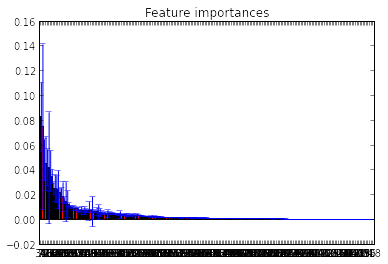

In [56]:
# Feature Importance Code
forest = ExtraTreesClassifier(n_estimators=10,random_state=0)

forest.fit(train, trainlabels)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(train.shape[1]), indices)
plt.xlim([-1, train.shape[1]])
plt.show()


In [59]:
# How to find feature 19
#pd.get_dummies(injury_labels).columns[19]